In [1]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-03-17 09:52:43--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-17 09:52:43 (64.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# Working with 10% of data

In [2]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2023-03-17 09:52:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.31.128, 142.250.153.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  34.7MB/s    in 5.1s    

2023-03-17 09:52:55 (31.2 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:

# Walk through 10 percent data directory and list number of files
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/gr

In [4]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

For this case we are going to use `tf.keras.preprocessing.image_dataset_from_directory()` instead of `ImageDataGenerator`. One of the advantages is that it is faster

In [5]:
import tensorflow as tf

img_size = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size=img_size,
    label_mode='categorical',
    batch_size=32
)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=img_size,
    label_mode='categorical'
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

# Importing the models to use as baseline

In this case we are not going to use tensorflow hub, but a module in keras:
`tf.keras.applications.EfficientNetB0`

In [7]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # this means 
#that the final layer won't be included and we are going to put our own output layer

#2. We are not going to train the base model so we need to freeze these weights
base_model.trainable = False

#3. We need to define the inputs for the base model
inputs = tf.keras.layers.Input(shape=(224,224,3), name='input_layer')

#4. For this specific model normalization is not needed but for other models
# this may be necessary, one way to do it is:
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255)(inputs)

#5. connect the inputs with the base model
x = base_model(inputs)

#6. Making an average to reduce the amount of parameters and flatten the weights
# This is necessary because 'dense' layer only accepts vectors and not matrices

x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
# this globalaverage, takes a 4d dimension and takes the mean for the two inner
# dimensions and returns a 2d dimension

#7. Creating the output layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

#8. forming the model, remember we are using 'Functional' API and this step is necessary
model_0 = tf.keras.Model(inputs, outputs)

#9. compile the model
model_0.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

16705208/16705208 [==============================] - 1s 0us/step


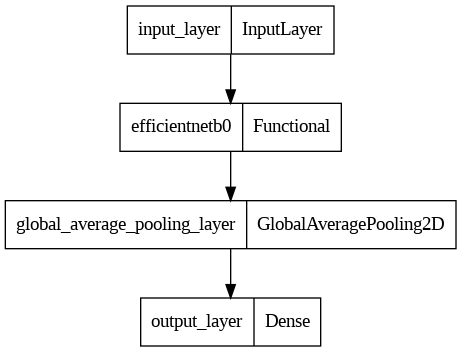

In [8]:
tf.keras.utils.plot_model(model_0)

In [9]:
history_10_percent = model_0.fit(train_data_10_percent, epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 validation_steps=int(0.25*len(test_data_10_percent)),
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20230317-095313
Epoch 1/5
24/24 [==============================] - 29s 269ms/step - loss: 1.8546 - accuracy: 0.4200 - val_loss: 1.2698 - val_accuracy: 0.7220
Epoch 2/5
24/24 [==============================] - 6s 216ms/step - loss: 1.0827 - accuracy: 0.7547 - val_loss: 0.8505 - val_accuracy: 0.8158
Epoch 3/5
24/24 [==============================] - 4s 143ms/step - loss: 0.7943 - accuracy: 0.8280 - val_loss: 0.7176 - val_accuracy: 0.8158
Epoch 4/5
24/24 [==============================] - 7s 290ms/step - loss: 0.6412 - accuracy: 0.8667 - val_loss: 0.6285 - val_accuracy: 0.8454
Epoch 5/5
24/24 [==============================] - 5s 179ms/step - loss: 0.5505 - accuracy: 0.8760 - val_loss: 0.5864 - val_accuracy: 0.8388


## We can go through each layer in our model

In [10]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

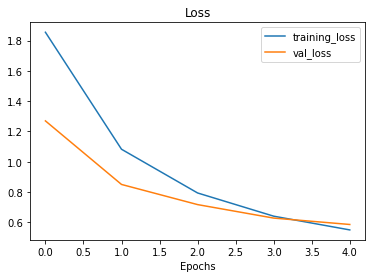

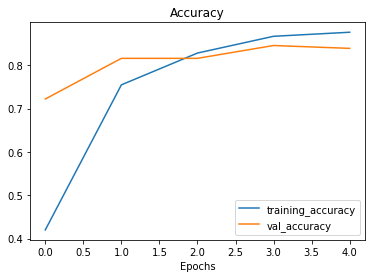

In [11]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

# Working with 1% data

In [12]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2023-03-17 09:54:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.96.128, 108.177.119.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.96.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  39.7MB/s    in 3.7s    

2023-03-17 09:54:20 (34.5 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [13]:
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           batch_size=32,
                                                                           image_size=img_size)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=img_size)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Augmenting data. In this ocasion we are going to use `keras.sequential` and then introduce this layer to the architecture of our model

In [14]:
from tensorflow import keras

In [15]:
data_augmentation = keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
], name='data_augmentation')

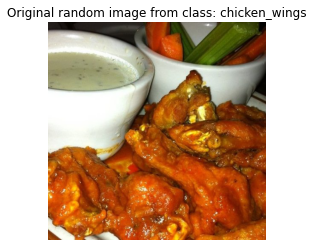

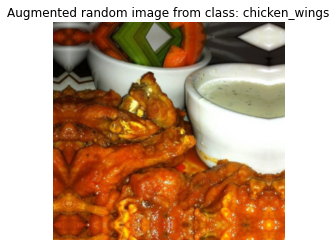

In [16]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

### Making the model

In [17]:
input_shape = (224,224,3)
base_model = keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Creating input layer
input = keras.layers.Input(shape=input_shape, name='input_layer')

#Adding data augmentation as a layer
x = data_augmentation(input)
x = base_model(x, training=False)
x= keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
outputs = keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

#Make model with inputs and outputs
model_1 = keras.Model(input, outputs)

In [18]:
#Compiling the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [19]:
#Fitting the model 
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230317-095431


Epoch 1/5


3/3 [==============================] - 23s 4s/step - loss: 2.3016 - accuracy: 0.1000 - val_loss: 2.1850 - val_accuracy: 0.1480
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.0672 - accuracy: 0.2429 - val_loss: 2.0593 - val_accuracy: 0.2336
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.8616 - accuracy: 0.4143 - val_loss: 1.9591 - val_accuracy: 0.3109
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.6686 - accuracy: 0.5714 - val_loss: 1.8672 - val_accuracy: 0.3832
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.4854 - accuracy: 0.7143 - val_loss: 1.7636 - val_accuracy: 0.4655


## Using 10% of the data

In [20]:

# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
], name="data_augmentation")

input_shape = (224,224,3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Creating architecture
inputs = layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

model_2 = keras.Model(inputs,outputs)


In [21]:
#Compiling the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                metrics=['accuracy'])

### **Now we are going to use something new: a callback that enables us to create checkpoints**

In [22]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                      save_weights_only=True,
                                                      save_best_only=False,
                                                      save_freq='epoch',
                                                      verbose=1)

## Now we are going to fit the model, in this step is where the checkpoints are included

In [23]:
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                         epochs=initial_epochs,
                                         validation_data=test_data,
                                         validation_steps=int(0.25*len(test_data)),
                                         callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230317-095519
Epoch 1/5


24/24 [==============================] - ETA: 0s - loss: 1.9841 - accuracy: 0.3667
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 32s 820ms/step - loss: 1.9841 - accuracy: 0.3667 - val_loss: 1.4240 - val_accuracy: 0.7418
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2943 - accuracy: 0.7027
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 16s 667ms/step - loss: 1.2943 - accuracy: 0.7027 - val_loss: 0.9773 - val_accuracy: 0.8174
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9919 - accuracy: 0.7747
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 14s 556ms/step - loss: 0.9919 - accuracy: 0.7747 - val_loss: 0.7851 - val_accuracy: 0.8339
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.8188 - accuracy: 0.8200
Epoch

In [24]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug


79/79 [==============================] - 11s 128ms/step - loss: 0.6053 - accuracy: 0.8532


[0.6052717566490173, 0.8532000184059143]

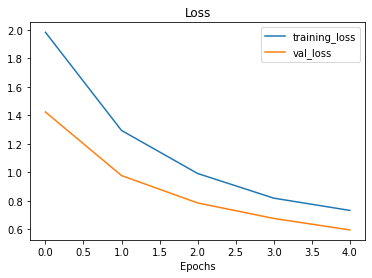

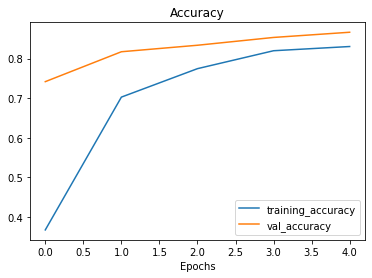

In [25]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### loading the weights from the callback

In [26]:
model_2.load_weights(checkpoint_path)

## **Fine tuning the model**
Fine tuning 10 layers of the imported model

The basic idea is to set the loaded model as trainable and then go trhough each layer and set as `False` the layers we don't want to train 

In [27]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [28]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

### Time to fine-tuning
I am gonna continue training the model from the epoch I ended last time (epoch=5) and doing it for 5 more epochs

In [33]:
fine_tune_epochs = initial_epochs + 5

history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               validation_data = test_data,
                                               initial_epoch = history_10_percent_data_aug.epoch[-1],
                                               validation_steps = int(0.10*len(test_data)),
                                               callbacks = [create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230317-100703
Epoch 5/10
24/24 [==============================] - 12s 435ms/step - loss: 0.0850 - accuracy: 0.9733 - val_loss: 0.5553 - val_accuracy: 0.8393
Epoch 6/10
24/24 [==============================] - 12s 455ms/step - loss: 0.0586 - accuracy: 0.9840 - val_loss: 0.5280 - val_accuracy: 0.8616
Epoch 7/10
24/24 [==============================] - 12s 471ms/step - loss: 0.0419 - accuracy: 0.9880 - val_loss: 0.6629 - val_accuracy: 0.8304
Epoch 8/10
24/24 [==============================] - 10s 368ms/step - loss: 0.0427 - accuracy: 0.9867 - val_loss: 0.6377 - val_accuracy: 0.8527
Epoch 9/10
24/24 [==============================] - 11s 402ms/step - loss: 0.0475 - accuracy: 0.9840 - val_loss: 0.7932 - val_accuracy: 0.7902
Epoch 10/10
24/24 [==============================] - 11s 429ms/step - loss: 0.0485 - accuracy: 0.9840 - val_loss: 0.5514 - val_accuracy: 0.8259


Let's evaluate the model

In [30]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 8s 84ms/step - loss: 0.5936 - accuracy: 0.8328


### Function to compare before and after fine tuning

In [31]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.36666667461395264, 0.7026666402816772, 0.7746666669845581, 0.8199999928474426, 0.8306666612625122, 0.9733333587646484, 0.984000027179718, 0.9879999756813049, 0.9866666793823242, 0.984000027179718, 0.984000027179718]


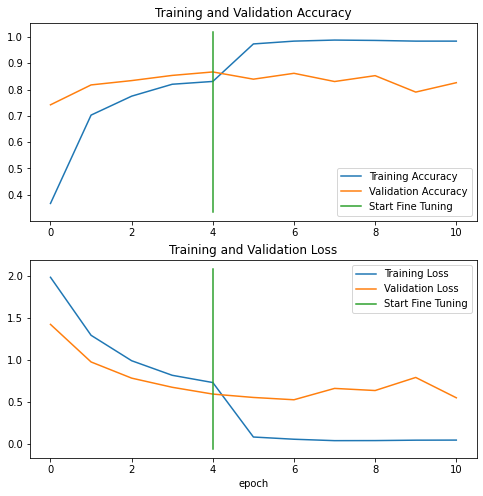

In [34]:
compare_historys(original_history=history_10_percent_data_aug, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)